In [40]:
from glob import glob
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import shutil
from torchvision import models
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torchvision.datasets as datasets

> 이미지분류

In [41]:
path = '/Users/taehoonkim/Desktop/kickandkick'

files = glob(os.path.join(path,'*/*.jpg'))

print(f'Total no of images {len(files)}')

no_of_images = len(files)

shuffle = np.random.permutation(no_of_images)

for t in ['train', 'valid']:
    os.mkdir(os.path.join(path, t))

Total no of images 0


FileExistsError: [Errno 17] File exists: '/Users/taehoonkim/Desktop/kickandkick/train'

In [ ]:
for t in ['train', 'valid']:
    for folder in ['ehffu/','ehfro/']:
        os.mkdir(os.path.join(path,t,folder))

In [ ]:
for t in ['train', 'valid']:   
    for i in shuffle[:50]:
        folder = files[i].split('/')[-1].split('.')[0].split('_')[0]
        image = files[i].split('/')[-1]
        shutil.copy(files[i],os.path.join(path,t, folder, image))

>> 파이토치 Tensor로 데이터 로딩

In [42]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder(os.path.join(path, 'train'),simple_transform)
valid = ImageFolder(os.path.join(path, 'valid'),simple_transform)

In [43]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.255])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

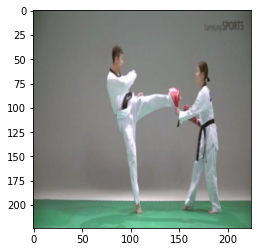

In [44]:
imshow(train[50][0])

In [52]:
train_data_gen = torch.utils.data.DataLoader(train,batch_size=64,shuffle=True)
valid_data_gen = torch.utils.data.DataLoader(valid,batch_size=64,shuffle=True)

In [64]:
import random

## 이미지분류 및 Tensor로 로딩 마무리
---

# 아키텍처 구축

>네트워크 아키텍처

In [46]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cuda')

print('Current cuda device is', device)

Current cuda device is cuda


In [47]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if is_cuda:
    model_ft = model_ft.cuda()

/Users/taehoonkim/miniforge3/envs/kim/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/taehoonkim/miniforge3/envs/kim/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


>> 모델 학습

In [69]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma=0.01)

In [53]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 Epoch은 학습 단계와 검증 단계를 거침
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # 학습 모드 설정
            else:
                model.train(False)  # 검증 모드 설정

            running_loss = 0.0
            running_corrects = 0


            for data in dataloaders[phase]:
                inputs, labels = data
                if is_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backwart()
                    optimizer.step

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            ipoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델 복사(Deep Copy)
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model




In [72]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [73]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

NameError: name 'copy' is not defined

In [ ]:
import time


1675213727.845443